In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CS221n/Project/'
FOLDERNAME = 'CS221/Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import string
import re
import random
import pandas as pd
import numpy as np
from time import time
import spacy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_PATH = '/content/drive/My Drive/CS221/CS221Project/bbc_data_clean_text_and_summary.csv'
data = pd.read_csv(DATA_PATH)
data.head()

,Unnamed: 0,File,Text,Summary
0,0,002.txt,dollar gains on greenspan speechthe dollar has...,the dollar has hit its highest level against t...
1,1,003.txt,yukos unit buyer faces loan claimthe owners of...,yukos owner menatep group says it will ask ros...
2,2,006.txt,japan narrowly escapes recessionjapans economy...,on an annual basis the data suggests annual gr...
3,3,005.txt,pernod takeover talk lifts domecqshares in uk ...,pernod has reduced the debt it took on to fund...
4,4,007.txt,jobs growth still slow in the usthe us created...,the job gains mean that president bush can cel...


In [4]:
brief_cleaning1 = data['Text']
brief_cleaning2 = data['Summary']

nlp = spacy.load('en', disable=['File']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.41 mins


In [5]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.58 mins


In [6]:
text[0]

'dollar gains on greenspan speechthe dollar has hit its highest level against the euro in almost three months after the federal reserve head said the us trade deficit is set to stabiliseand alan greenspan highlighted the us governments willingness to curb spending and rising household savings as factors which may help to reduce it in late trading in new york the dollar reached 12871 against the euro from 12974 on thursday market concerns about the deficit has hit the greenback in recent months on friday federal reserve chairman mr greenspans speech in london ahead of the meeting of g7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worsethanexpected us jobs data i think the chairmans taking a much more sanguine view on the current account deficit than hes taken for some time said robert sinche head of currency strategy at bank of america in new york hes taking a longerterm view laying out a set of conditions under which the current account deficit c

In [7]:
summary[0]


'_START_ the dollar has hit its highest level against the euro in almost three months after the federal reserve head said the us trade deficit is set to stabilisechinas currency remains pegged to the dollar and the us currencys sharp falls in recent months have therefore made chinese export prices highly competitivemarket concerns about the deficit has hit the greenback in recent monthsi think the chairmans taking a much more sanguine view on the current account deficit than hes taken for some time said robert sinche head of currency strategy at bank of america in new yorkthe recent falls have partly been the result of big budget deficits as well as the uss yawning current account gap both of which need to be funded by the buying of us bonds and assets by foreign firms and governmentshes taking a longerterm view laying out a set of conditions under which the current account deficit can improve this year and next _END_'

In [8]:
data['cleaned_text'] = pd.Series(text)
data['cleaned_summary'] = pd.Series(summary)

In [9]:
text_count = []
summary_count = []

In [10]:
for sent in data['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in data['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [11]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

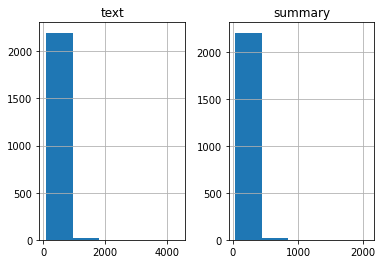

In [12]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [24]:
text_len, summary_len = 700, 300

In [28]:
#Check how much % of summary have 0-300 words
cnt=0
max_length=0
for i in data['cleaned_summary']:
    length = len(i.split())
    if(length<=summary_len):
        cnt=cnt+1
    max_length=max(max_length, length)
print(cnt/len(data['cleaned_summary']))
print(max_length)

0.939748201438849
2068


In [29]:
#Check how much % of text have 0-500 words
cnt=0
for i in data['cleaned_text']:
    length = len(i.split())
    if(length<=text_len):
        cnt=cnt+1
    max_length=max(max_length, length)
print(cnt/len(data['cleaned_text']))
print(max_length)

0.9433453237410072
4362


In [30]:
#Model to summarize the text between 0-500 words for Summary and 0-1000 words for Text
max_text_len=text_len
max_summary_len=summary_len

In [31]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [32]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [33]:
post_pre.head()

,text,summary
0,dollar gains on greenspan speechthe dollar has...,sostok _START_ the dollar has hit its highest ...
1,yukos unit buyer faces loan claimthe owners of...,sostok _START_ yukos owner menatep group says ...
2,japan narrowly escapes recessionjapans economy...,sostok _START_ on an annual basis the data sug...
3,pernod takeover talk lifts domecqshares in uk ...,sostok _START_ pernod has reduced the debt it ...
4,jobs growth still slow in the usthe us created...,sostok _START_ the job gains mean that preside...


# Model building

In [64]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.3,random_state=0,shuffle=True)

In [65]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [66]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.42955893077972
Total Coverage of rare words: 6.251591364163192


In [67]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 9642


In [68]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [69]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 83.76008562489709
Total Coverage of rare words: 14.612546462877704


In [70]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 3946


In [71]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [72]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [73]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)


Size of vocabulary from the w2v model = 9642


In [74]:
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_outputs, state_h, state_c= encoder_lstm1(enc_emb)

# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 200)     1928400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    789200      input_2[0][0]                    
_______________________________________________________________________________________

In [75]:
checkpoint_path = '/content/drive/My Drive/CS221/CS221Project/checkpoint/checkpoint.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [77]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [78]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/30
12/12 [==============================] - 44s 4s/step - loss: 4.7030 - val_loss: 3.1122
Epoch 2/30
12/12 [==============================] - 45s 4s/step - loss: 3.1653 - val_loss: 2.9791
Epoch 3/30
12/12 [==============================] - 45s 4s/step - loss: 3.0146 - val_loss: 2.9071
Epoch 4/30
12/12 [==============================] - 43s 4s/step - loss: 2.8242 - val_loss: 2.6955
Epoch 5/30
12/12 [==============================] - 45s 4s/step - loss: 2.7670 - val_loss: 2.6817
Epoch 6/30
12/12 [==============================] - 44s 4s/step - loss: 2.7483 - val_loss: 2.6584
Epoch 7/30
12/12 [==============================] - 44s 4s/step - loss: 2.7291 - val_loss: 2.6483
Epoch 8/30
12/12 [==============================] - 44s 4s/step - loss: 2.7133 - val_loss: 2.6293
Epoch 9/30
12/12 [==============================] - 43s 4s/step - loss: 2.6914 - val_loss: 2.6055
Epoch 10/30
12/12 [==============================] - 44s 4s/step - loss: 2.6687 - val_loss: 2.5858
Epoch 11/30
12/12 [

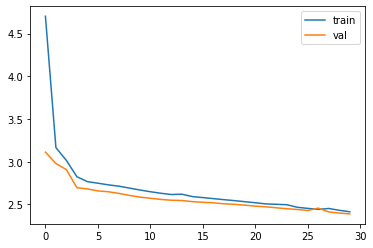

In [79]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [80]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [81]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [82]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [83]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [84]:
# Because the actual output (500~1000 words) is usually much longer than the
# predicted output, instead of how many n-grams are matched in the actual
# output, we compute the number of bigrams in the predicted output that also
# appear in the actual output.
#
# Params
# n: n-gram to compare.
def computeCustomizedRougeN(predicted_output: str, actual_output: str, n: int):
  predicted_words = predicted_output.split()
  actual_words = actual_output.split()
  assert n <= len(predicted_words) and n <= len(actual_words)
  predicted_ngrams = [''.join(predicted_words[i : i + n]) for i in range(len(predicted_words) - n + 1)]
  actual_ngrams = set([''.join(actual_words[i : i + n]) for i in range(len(actual_words) - n + 1)])
  
  actual_ngrams_list = [''.join(actual_words[i : i + n]) for i in range(len(actual_words) - n + 1)]

  num_matches = 0
  for predicted_ngram in predicted_ngrams:
    if predicted_ngram in actual_ngrams:
      num_matches += 1

  # (recall ROUGE score, precision ROUGE score)
  return (num_matches / len(predicted_ngrams), num_matches / len(actual_ngrams_list))

In [85]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: daylewis set for berlin daniel daylewis is to be presented with an award for his career in film at the berlin film festivalthe whose credits include his oscarwinning performance in my left foot will be presented with the berlinale camera award on 15 february the honour awarded since 1986 honours figures in cinema that the festival feels particularly to man to man a historical epic starring scott thomas opens the german festival on 10 february a documentary about the life and career of singer george michael a different story will also be screened at the 10day event daylewis has competed four times at the berlin film festival with films in the name of the father 1994 the 1997 the boxer 1998 and martin scorseses gangs of new york 2003 the festival him for his start with roles in my beautiful and costume classic a room with a view and a great number of celebrated roles in subsequent productions japans film studio will also be honoured along with daylewis film studios which was foun

In [86]:
rouge_score_recall_2, rouge_score_precision_2 = [], []
rouge_score_recall_3, rouge_score_precision_3 = [], []
rouge_score_recall_4, rouge_score_precision_4 = [], []
for i in range(10):
  print('=' * 10, "Round", i, '=' * 10)
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  predicted_summary = ' '.join(decode_sequence(x_val[i].reshape(1,max_text_len)).split()[1:])
  print("Predicted summary:", predicted_summary)
  actual_output = seq2summary(y_val[i])
  predicted_output = predicted_summary
  custom_rouge2_score_recall, custom_rouge2_score_precision = computeCustomizedRougeN(predicted_output, actual_output, 2)
  custom_rouge3_score_recall, custom_rouge3_score_precision = computeCustomizedRougeN(predicted_output, actual_output, 3)
  custom_rouge4_score_recall, custom_rouge4_score_precision = computeCustomizedRougeN(predicted_output, actual_output, 4)
  rouge_score_recall_2.append(custom_rouge2_score_recall)
  rouge_score_precision_2.append(custom_rouge2_score_precision)
  rouge_score_recall_3.append(custom_rouge3_score_recall)
  rouge_score_precision_3.append(custom_rouge3_score_precision)
  rouge_score_recall_4.append(custom_rouge4_score_recall)
  rouge_score_precision_4.append(custom_rouge4_score_precision)
  print("Input:", input)
  print("Predicted Output:", predicted_output)
  print("Actual Output:", actual_output)
  print("Customized Rouge2 score recall:", custom_rouge2_score_recall)
  print("Customized Rouge3 score recall:", custom_rouge3_score_recall)
  print("Customized Rouge4 score recall:", custom_rouge4_score_recall)
  print("Customized Rouge2 score precision:", custom_rouge2_score_precision)
  print("Customized Rouge3 score precision:", custom_rouge3_score_precision)
  print("Customized Rouge4 score precision:", custom_rouge4_score_precision)

========== Round 0 ==========
Review: sydney return for champion heninhardenne will return to action in januarys sydney international belgian has not competed since losing her top world ranking at the us open in september where she was beaten in the fourth round by she took time out to shake off a virus but will defend her titles in sydney and at the australian open womens world number one lindsay davenport and french open champion myskina will also the mens event world number three lleyton hewitt returns to defend his title along with runnerup carlos moya moya spains davis cup final hero in their recent win over the us had to retire with an ankle injury in the first set of the director craig watson said i had a message to me from him after spains davis cup victory saying he was looking forward to trying to make up for his disappointment in the 2004 final the tournament will take place from january 
Original summary: start in the mens event world number three lleyton hewitt to defend h

In [87]:
# average ROUGE scores
print('*' * 10, "Average scores", '*' * 10)
print("rouge2 recall score average:", np.mean(rouge_score_recall_2))
print("rouge2 precision score average:", np.mean(rouge_score_precision_2))
print("rouge3 recall score average:", np.mean(rouge_score_recall_3))
print("rouge3 precision score average:", np.mean(rouge_score_precision_3))
print("rouge4 recall score average:", np.mean(rouge_score_recall_4))
print("rouge4 precision score average:", np.mean(rouge_score_precision_4))

********** Average scores **********
rouge2 recall score average: 0.16565656565656567
rouge2 precision score average: 0.3017718639992258
rouge3 recall score average: 0.0
rouge3 precision score average: 0.0
rouge4 recall score average: 0.0
rouge4 precision score average: 0.0
